In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

class Map:
    """
    A navigation map that wraps a NetworkX graph to store locations (nodes) and
    routes (edges) with arbitrary attributes.
    Each node can store x,y coordinates for visualization in a 2D plane.
    """

    def __init__(self):
        # Use an undirected NetworkX graph internally
        self._G = nx.Graph()

    def copy_map(self):
        """
        Returns a new Map object that is a copy of the current one,
        including all nodes, edges, and attributes.
        """
        new_map = Map()
        # NetworkX provides a copy method that duplicates the entire graph
        new_map._G = self._G.copy()
        return new_map

    def add_location(self, location, x=None, y=None):
        """
        Add (or update) a location (node) in the map with optional x,y coordinates.
        """
        if location not in self._G:
            self._G.add_node(location, x=x, y=y)
        else:
            current_data = self._G.nodes[location]
            if x is not None:
                current_data['x'] = x
            if y is not None:
                current_data['y'] = y

    def remove_location(self, location):
        """
        Remove a location (node) from the map, including all connected routes (edges).
        """
        if location in self._G:
            self._G.remove_node(location)

    def add_route(self, loc1, loc2, **attributes):
        """
        Add (or update) an undirected route (edge) between loc1 and loc2
        with any number of attributes.
        """
        if loc1 not in self._G:
            self.add_location(loc1)
        if loc2 not in self._G:
            self.add_location(loc2)
        self._G.add_edge(loc1, loc2, **attributes)

    def remove_route(self, loc1, loc2):
        """
        Remove a route (edge) between loc1 and loc2.
        """
        if self._G.has_edge(loc1, loc2):
            self._G.remove_edge(loc1, loc2)

    def shortest_path(self, start, end, attr_weights):
        """
        Compute the shortest path between 'start' and 'end' based on multiple
        weighted attributes.
        """
        if start not in self._G or end not in self._G:
            return None, float('inf')

        def edge_cost(u, v, data):
            cost = 0
            for attr_name, weight_factor in attr_weights.items():
                if attr_name not in data:
                    raise ValueError(f"Edge from {u} to {v} is missing required attribute '{attr_name}'")
                cost += data[attr_name] * weight_factor
            return cost

        try:
            path = nx.shortest_path(self._G, source=start, target=end, weight=edge_cost)
            total_cost = nx.shortest_path_length(self._G, source=start, target=end, weight=edge_cost)
            return path, total_cost
        except nx.NetworkXNoPath:
            return None, float('inf')

    def visualize_map(self, path=None, title="Map Visualization"):
        """
        Visualize the map in a 2D plane based on node coordinates (x,y).
        """
        # Build pos from each node's x,y attributes
        pos = {}
        for node, data in self._G.nodes(data=True):
            x = data.get('x')
            y = data.get('y')
            if x is None or y is None:
                raise ValueError(f"Node '{node}' does not have x,y coordinates.")
            pos[node] = (x, y)

        # Draw nodes and edges
        nx.draw_networkx_nodes(self._G, pos, node_size=800, node_color='lightblue')
        nx.draw_networkx_edges(self._G, pos)
        nx.draw_networkx_labels(self._G, pos, font_size=10, font_color='black')

        # If a path is specified, highlight it
        if path and len(path) > 1:
            path_edges = list(zip(path, path[1:]))
            nx.draw_networkx_edges(
                self._G, pos,
                edgelist=path_edges,
                edge_color='red',
                width=2
            )

        plt.title(title)
        plt.axis('equal')  # Keep the aspect ratio
        plt.show()

    def generate_coordinates(self):
        """
        Randomly pick one existing edge (u, v). Then choose a random point on the
        line segment between them and return (x, y, u, v).
        """
        edges_list = list(self._G.edges(data=True))
        if not edges_list:
            raise ValueError("No edges exist in the map. Cannot generate a coordinate.")

        u, v, data = random.choice(edges_list)

        x_u = self._G.nodes[u].get('x')
        y_u = self._G.nodes[u].get('y')
        x_v = self._G.nodes[v].get('x')
        y_v = self._G.nodes[v].get('y')

        if x_u is None or y_u is None or x_v is None or y_v is None:
            raise ValueError(f"Edge from {u} to {v} has missing node coordinates.")

        t = random.random()
        x = x_u + t * (x_v - x_u)
        y = y_u + t * (y_v - y_u)

        return x, y, u, v

    def add_coordinates(self, new_node, x, y, u, v):
        """
        Insert a new node with coordinates (x, y) between two existing nodes u and v.
        The original edge (u, v) is removed. Two new edges:
            (u, new_node) and (new_node, v)
        are created with the same attributes as (u, v).
        """
        if not self._G.has_edge(u, v):
            raise ValueError(f"No edge found between {u} and {v}.")

        # Copy the original edge's attributes
        original_data = dict(self._G[u][v])

        # Remove the original edge
        self.remove_route(u, v)

        # Create the new node
        self.add_location(new_node, x, y)

        # Add edges (u, new_node) and (new_node, v) with the same attributes
        self.add_route(u, new_node, **original_data)
        self.add_route(new_node, v, **original_data)

    def __str__(self):
        return nx.info(self._G)


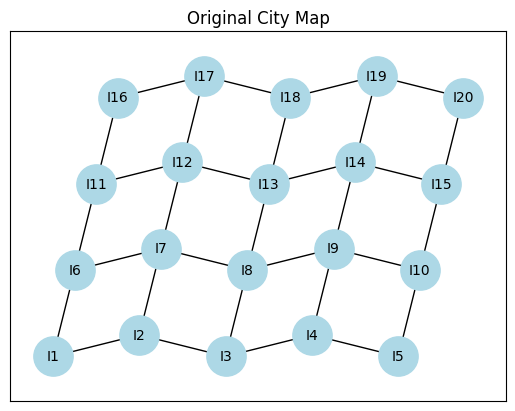

In [105]:
import random

# 1) Create an original city map
original_map = Map()

# Define 20 nodes manually with uniform spacing
locations = {
    "I1": (10, 10), "I2": (30, 15), "I3": (50, 10), "I4": (70, 15), "I5": (90, 10),
    "I6": (15, 30), "I7": (35, 35), "I8": (55, 30), "I9": (75, 35), "I10": (95, 30),
    "I11": (20, 50), "I12": (40, 55), "I13": (60, 50), "I14": (80, 55), "I15": (100, 50),
    "I16": (25, 70), "I17": (45, 75), "I18": (65, 70), "I19": (85, 75), "I20": (105, 70)
}

# Add locations to the map
for name, (x, y) in locations.items():
    original_map.add_location(name, x=x, y=y)

def random_value():
    return random.randint(0, 10000)

# Define complex route connections ensuring variety
routes = [
    ("I1", "I2"), ("I2", "I3"), ("I3", "I4"), ("I4", "I5"),
    ("I6", "I7"), ("I7", "I8"), ("I8", "I9"), ("I9", "I10"),
    ("I11", "I12"), ("I12", "I13"), ("I13", "I14"), ("I14", "I15"),
    ("I16", "I17"), ("I17", "I18"), ("I18", "I19"), ("I19", "I20"),
    ("I1", "I6"), ("I6", "I11"), ("I11", "I16"), ("I2", "I7"),
    ("I7", "I12"), ("I12", "I17"), ("I3", "I8"), ("I8", "I13"),
    ("I13", "I18"), ("I4", "I9"), ("I9", "I14"), ("I14", "I19"),
    ("I5", "I10"), ("I10", "I15"), ("I15", "I20")
]

# Add routes with random attributes
for route in routes:
    original_map.add_route(route[0], route[1], distance=random_value(), speed=random_value(), traffic=random_value())

# 2) Plot the original map (no path yet)
original_map.visualize_map( title="Original City Map")

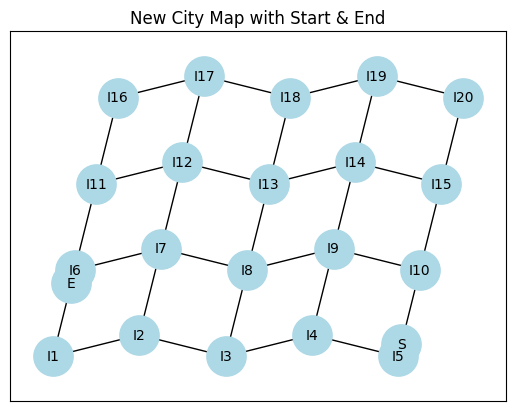

In [111]:
# 3) Generate random coordinates for a start point and an end point
#    Each call returns (x, y, u, v) for some random edge (u, v).
x1, y1, u1, v1 = original_map.generate_coordinates()
x2, y2, u2, v2 = original_map.generate_coordinates()

# Name these new nodes "S" (start) and "E" (end) for simplicity
start_name = "S"
end_name   = "E"

# 4) Make a copy of the original map, then add the new start/end nodes
new_map = original_map.copy_map()

# Insert S
new_map.add_coordinates(new_node=start_name, x=x1, y=y1, u=u1, v=v1)
# Insert E
new_map.add_coordinates(new_node=end_name, x=x2, y=y2, u=u2, v=v2)

# 5) Plot the new map (now with S and E included, but no path)
new_map.visualize_map(title="New City Map with Start & End")

Shortest path from S to E: ['S', 'I10', 'I15', 'I14', 'I13', 'I12', 'I7', 'I6', 'E']
Total weighted cost: 29871.0


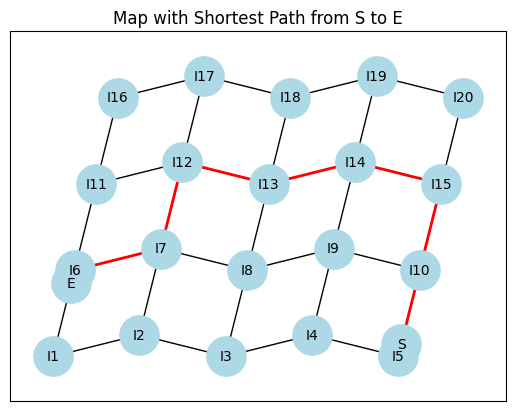

Shortest path from S to E: ['S', 'I10', 'I9', 'I8', 'I3', 'I2', 'I1', 'E']
Total weighted cost: 34256


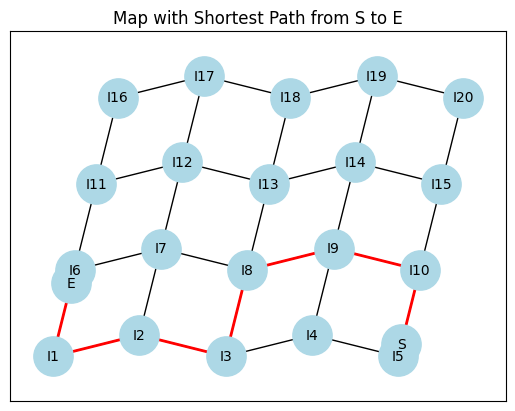

Shortest path from S to E: ['S', 'I10', 'I15', 'I14', 'I13', 'I12', 'I7', 'I6', 'E']
Total weighted cost: 28285


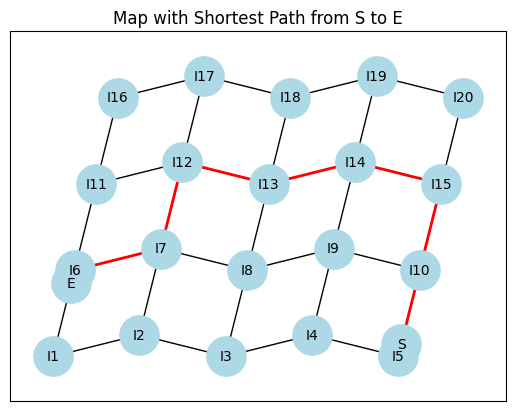

Shortest path from S to E: ['S', 'I10', 'I15', 'I14', 'I13', 'I12', 'I7', 'I2', 'I1', 'E']
Total weighted cost: 28815


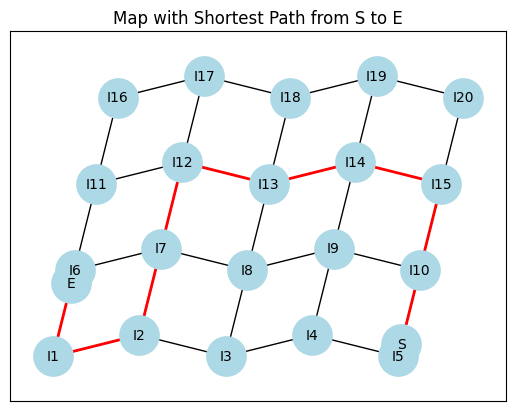

In [112]:

random_weights = {"distance": 0.6, "traffic": 0.3, "speed": 0.1}
speed_weights = {"distance": 0, "traffic": 0, "speed": 1}
traffic_weights = {"distance": 0, "traffic": 1, "speed": 0}
distance_weights = {"distance": 1, "traffic": 0, "speed": 0}


# 7) Compute the shortest path from S to E
weights_list = [random_weights, speed_weights, traffic_weights, distance_weights ]

for weights in weights_list:
    path, total_cost = new_map.shortest_path(start_name, end_name, weights)
    if path is None:
        print("No path found from S to E!")
    else:
        print("Shortest path from S to E:", path)
        print("Total weighted cost:", total_cost)

    # 8) Visualize the new map, highlighting the shortest path
    new_map.visualize_map(path=path, title="Map with Shortest Path from S to E")